In [1]:
from subpred.protein_go_datasets import get_transmembrane_transporter_dataset, get_stats

## Full dataset

In [2]:
dataset_human = get_transmembrane_transporter_dataset(
    organism_ids=[9606],
    swissprot_only=False,
    datasets_path="../data/datasets/",
    exclude_iea_go_terms=False,
    max_sequence_evidence_code=2,
    remove_proteins_without_gene_names=False,
)
get_stats(*dataset_human)

cd-hit: clustered 3874 sequences into 1029 clusters at threshold 50
cd-hit: clustered 3874 sequences into 1347 clusters at threshold 70
cd-hit: clustered 3874 sequences into 1774 clusters at threshold 90
cd-hit: clustered 3874 sequences into 3408 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence   protein_existence_evidence clustering                   
False              False         computational protein_level              50                       1   
                                                                          70                       1   
                                                                          90                       5   
                                                                          100                      9   
                                                                          None                    10   
                                               transcript_level           50                      54   
                                                                          70                      77   
                                                                          90                     152   
                                                                          100                    665   
                                                                          None                   771   
                                 experiment    transcript_level           50                       1   
                                                                          70                       1   
                                                                          90                       1   
                                                                          100                      2   
                                                                          None                     2   
                   True          computational protein_level              50                     142   
                                                                          70                     211   
                                                                          90                     419   
                                                                          100                   1031   
                                                                          None                  1175   
                                               transcript_level           50                      31   
                                                                          70                      46   
                                                                          90                     100   
                                                                          100                    501   
                                                                          None                   687   
                                 experiment    transcript_level           50                       1   
                                                                          70                       1   
                                                                          90                       2   
                                                                          100                      4   
                                                                          None                     5   
True               True          computational protein_level              50                     552   
                                                                          70                     741   
                                                                          90                     819   
                                                                          100                    919   
                                                                          None                   945   
                                               transcript_level           50                       6   
                                                                          70                      10   
                              

## Filtered Subset

In [3]:
dataset_human = get_transmembrane_transporter_dataset(  # human
    organism_ids=[9606],  # [3702, 9606, 83333, 559292]
    swissprot_only=True,
    datasets_path="../data/datasets/",
    exclude_iea_go_terms=True,
    max_sequence_evidence_code=1,
    remove_proteins_without_gene_names=True,
)
get_stats(*dataset_human)

cd-hit: clustered 1121 sequences into 846 clusters at threshold 50
cd-hit: clustered 1121 sequences into 1039 clusters at threshold 70
cd-hit: clustered 1121 sequences into 1110 clusters at threshold 90
cd-hit: clustered 1121 sequences into 1118 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering                   
True               True          experiment  protein_level              50                     846   
                                                                        70                    1039   
                                                                        90                    1110   
                                                                        100                   1118   
                                                                        None                  1121   

                                                                                    n_terms  
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering           
True               True          experiment  protein_level              50              534  
                                                                        70              563  
                                                                        90              570  
                                                                        100             570  
                                                                        None            570

## Sugar/Amino subset

In [4]:
from subpred.dataset_filters import get_classification_subset
dataset_human = get_classification_subset(
    dataset_full=dataset_human,
    go_terms=[
        "sugar transmembrane transporter activity",
        "amino acid transmembrane transporter activity",
    ],
)

print("before clustering:")
dataset_human[1].go_term_ancestor.value_counts()

before clustering:


go_term_ancestor
amino acid transmembrane transporter activity    96
sugar transmembrane transporter activity         26
Name: count, dtype: int64

In [5]:
from subpred.dataset_filters import filter_no_3Di_available

dataset_human = filter_no_3Di_available(dataset_human)
dataset_human[1].go_term_ancestor.value_counts()

go_term_ancestor
amino acid transmembrane transporter activity    96
sugar transmembrane transporter activity         25
Name: count, dtype: int64

Clustering at 70%

In [6]:
from subpred.dataset_filters import cluster_sequences

dataset_human = cluster_sequences(
    dataset_full=dataset_human, identity_threshold=70
)
dataset_human[1].go_term_ancestor.value_counts()

cd-hit: clustered 121 sequences into 108 clusters at threshold 70


go_term_ancestor
amino acid transmembrane transporter activity    84
sugar transmembrane transporter activity         24
Name: count, dtype: int64

human:

amino acid transmembrane transporter activity    84

sugar transmembrane transporter activity         25

ecoli:

amino acid transmembrane transporter activity    46

sugar transmembrane transporter activity         19

at:

amino acid transmembrane transporter activity    26

sugar transmembrane transporter activity         28

yeast:

amino acid transmembrane transporter activity    44

sugar transmembrane transporter activity         8

yeast+ecoli

amino acid transmembrane transporter activity    90

sugar transmembrane transporter activity         27

human+at

amino acid transmembrane transporter activity    110

sugar transmembrane transporter activity          53

all four

amino acid transmembrane transporter activity    200

sugar transmembrane transporter activity          80

## Feature generation

In [ ]:
from subpred.features import get_features
features_list, series_labels = get_features(dataset_full=dataset_human)

For each Feature: Outlier detection, numpy conversion 

In [8]:
# ml_datasets = [
#     (
#         feature_name,
#         *get_ml_dataset(df_features=df_features, series_labels=series_labels),
#     )
#     for feature_name, df_features in features_list
# ]
from subpred.features import get_ml_datasets
ml_datasets = get_ml_datasets(features_list=features_list, series_labels=series_labels)

In [9]:
# saving as pickle, to load in different notebook with different env, 
# as tensorflow on GPU has problems with current CUDA version (too new)
import pickle
with open("../data/tmp_data/ml_data_human_sugaramino.pickle", 'wb') as handle:
    pickle.dump(ml_datasets, handle)

# with open("../data/tmp/ml_data_at_sugaramino.pickle", "rb") as handle:
#     ml_datasets_from_pickle = pickle.load(handle)

In [10]:
from subpred.evaluation import outlier_check

outlier_check(dataset_full=dataset_human,ml_datasets=ml_datasets, threshold=0.8)

,outlier_count,protein_names,go_term_ancestor


In [11]:
import seaborn as sns

# sns.clustermap(X, row_colors=["yellow" if label == 1 else "blue" for label in y])

## Model evaluation SVM

=== DUMMY ===


Nested crossvalidation: 0.48+-0.08
=== AAC ===
Nested crossvalidation: 0.66+-0.11
=== PAAC ===
Nested crossvalidation: 0.70+-0.10
=== AA_KMER3 ===
Nested crossvalidation: 0.81+-0.08
=== PSSM_50_1 ===
Nested crossvalidation: 0.74+-0.11
=== PSSM_50_3 ===
Nested crossvalidation: 0.82+-0.11
=== PSSM_90_1 ===
Nested crossvalidation: 0.77+-0.13
=== PSSM_90_3 ===
Nested crossvalidation: 0.77+-0.13
=== PSSM_META ===
Nested crossvalidation: 0.75+-0.11
=== META ===
Nested crossvalidation: 0.74+-0.11
=== META_STD ===
Nested crossvalidation: 0.83+-0.10
=== 3Di_COMP ===
Nested crossvalidation: 0.79+-0.10
=== 3Di_KMER2 ===
Nested crossvalidation: 0.85+-0.09
=== 3Di_KMER3 ===
Nested crossvalidation: 0.82+-0.10
=== COMB_KMER1 ===
Nested crossvalidation: 0.79+-0.10
=== COMB_KMER2 ===
Nested crossvalidation: 0.84+-0.09
=== COMB_KMER3 ===
Nested crossvalidation: 0.86+-0.08
=== PROTT5_AA ===
Nested crossvalidation: 0.89+-0.08
=== PROSTT5_AA ===
Nested crossvalidation: 0.91+-0.08
=== PROSTT5_3DI ===
Nested

,median_val,std_val
Feature Name,,
DUMMY,0.500000,0.084758
AAC,0.669853,0.112195
PAAC,0.700000,0.097748
PSSM_50_1,0.741176,0.111742
META,0.745588,0.108776
PSSM_META,0.755882,0.107890
3Di_COMP,0.778676,0.099615
PSSM_90_1,0.784559,0.128400
PSSM_90_3,0.784559,0.128400


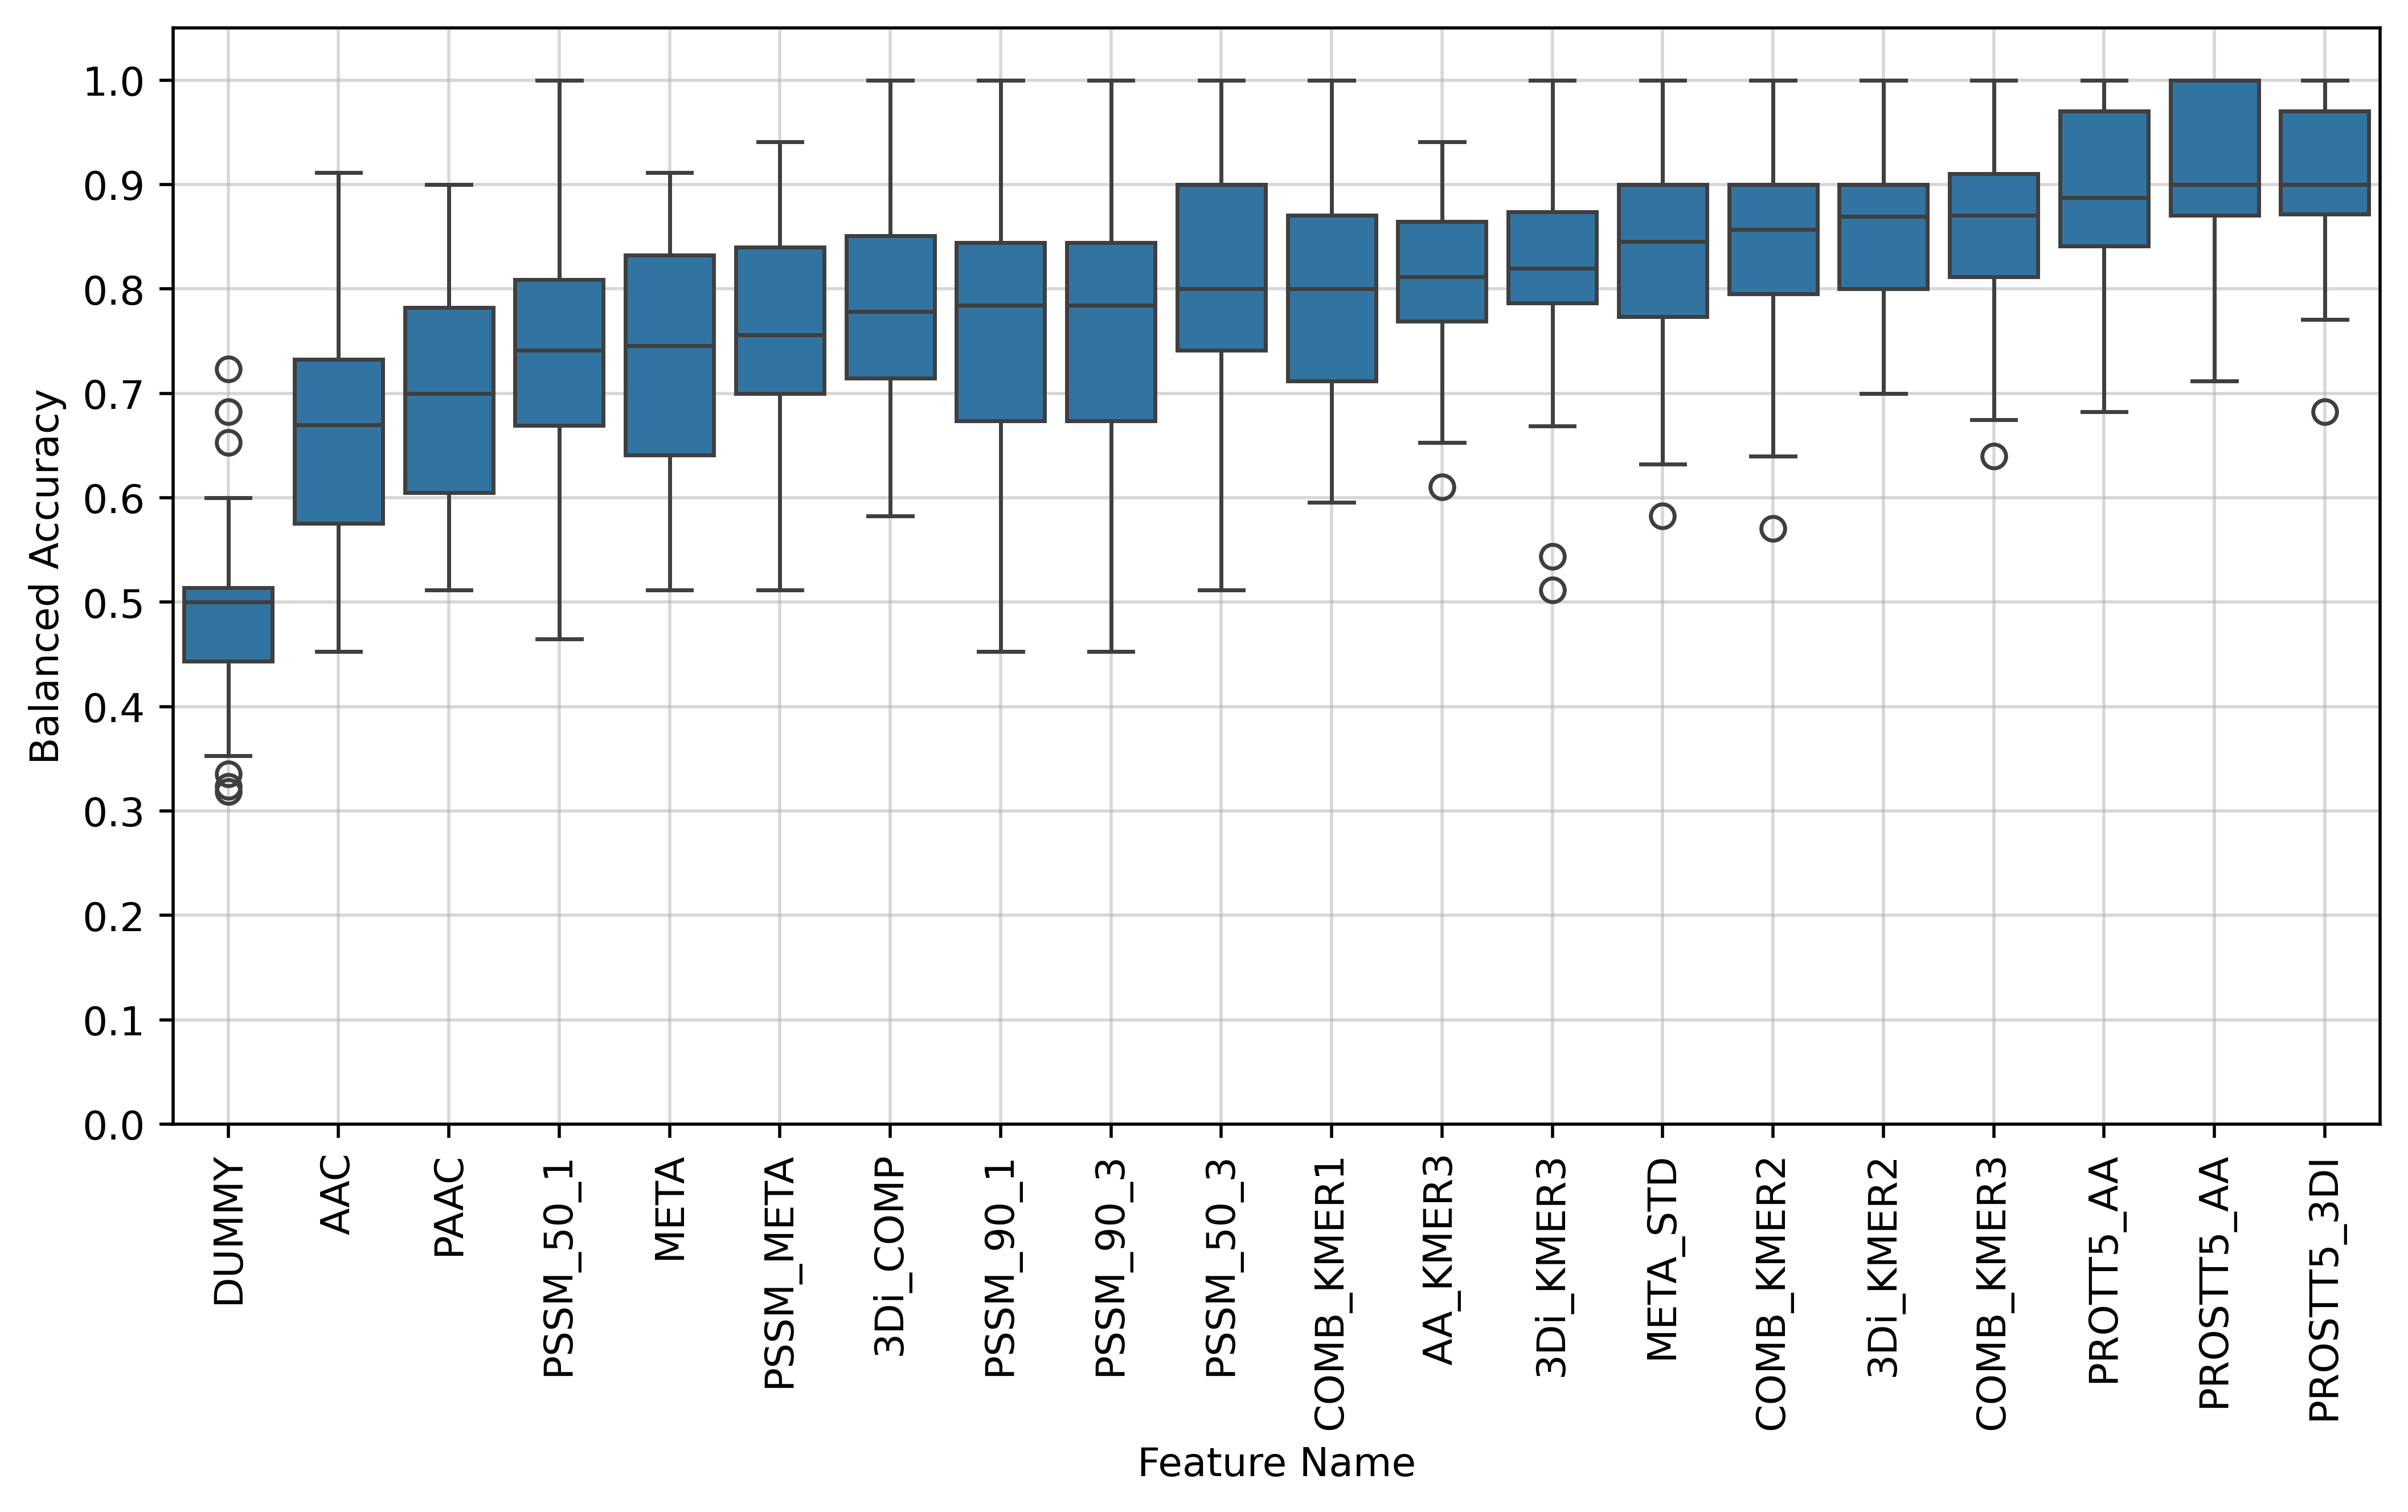

In [12]:
from subpred.evaluation import get_svm_results, plot_results_long


RESULTS_FOLDER = "../data/results/"
TEST_NAME = "svc_human_sugar_amino"
RECALCULATE = True

df_results_long = get_svm_results(
    ml_datasets=ml_datasets,
    recalculate=RECALCULATE,
    output_folder=RESULTS_FOLDER,
    test_name=TEST_NAME,
)
plot_results_long(
    df_results_long=df_results_long,
    output_folder_path=RESULTS_FOLDER,
    test_name=TEST_NAME,
)

In [13]:
# TODO linear svm, linear svm with nyström, DNN -> other?
# TODO maybe find all sugar transporters against background of all proteins?